In [2]:
import pennylane as qml
import numpy as np
import jax

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
jnp = jax.numpy

def two_qubit_decomp(params, wires):
    """Implement an arbitrary SU(4) gate on two qubits
    using the decomposition from Theorem 5 in
    https://arxiv.org/pdf/quant-ph/0308006.pdf"""
    i, j = wires
    # Single U(2) parameterization on both qubits separately
    qml.Rot(*params[:3], wires=i)
    qml.Rot(*params[3:6], wires=j)
    qml.CNOT(wires=[j, i])  # First CNOT
    qml.RZ(params[6], wires=i)
    qml.RY(params[7], wires=j)
    qml.CNOT(wires=[i, j])  # Second CNOT
    qml.RY(params[8], wires=j)
    qml.CNOT(wires=[j, i])  # Third CNOT
    # Single U(2) parameterization on both qubits separately
    qml.Rot(*params[9:12], wires=i)
    qml.Rot(*params[12:15], wires=j)


# The three building blocks on two qubits we will compare are:
operations = {
    ("Decomposition", "decomposition"): two_qubit_decomp,
    ("PauliRot sequence",) * 2: qml.ArbitraryUnitary,
    ("$\mathrm{SU}(N)$ gate", "SU(N) gate"): qml.SpecialUnitary,
}

<>:32: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\m'
C:\Users\DELL\AppData\Local\Temp\ipykernel_27600\2719096219.py:32: SyntaxWarning: invalid escape sequence '\m'
  ("$\mathrm{SU}(N)$ gate", "SU(N) gate"): qml.SpecialUnitary,


In [5]:
# Added the Noisy Channel in Hamiltonian
from qiskit.quantum_info import SparsePauliOp

num_wires = 4
wires = list(range(num_wires))
np.random.seed(62213)

# Define the Hamiltonian
hamiltonian = SparsePauliOp.from_list([
    ("IIZZ", 1), ("ZIZI", 1), ("IZZI", 1), ("ZIIZ", 1), ("ZZII", 1)
])

# Convert the SparsePauliOp to a matrix
H_matrix = hamiltonian.to_matrix()
H = qml.Hermitian(H_matrix, wires=wires)

# Compute the eigenvalues and eigenvectors of the Hamiltonian
eigenvalues, eigenvectors = np.linalg.eigh(H_matrix)

# Add noise to the eigenvalues
noise = np.random.randn(eigenvalues.shape[0]) * 10  # Adjust noise scale as needed
noisy_eigenvalues = eigenvalues + noise

# Reconstruct the noisy Hamiltonian using the noisy eigenvalues and original eigenvectors
noisy_H_matrix = eigenvectors @ np.diag(noisy_eigenvalues) @ np.linalg.inv(eigenvectors)
noisy_H = qml.Hermitian(noisy_H_matrix, wires=wires)

# Compute the ground state energy of the noisy Hamiltonian
E_min_noisy = min(qml.eigvals(noisy_H))
print(f"Noisy ground state energy: {E_min_noisy:.5f}")

# Optional: Print the noisy eigenvalues
print("Noisy eigenvalues:", qml.eigvals(noisy_H))
noisy_H



Noisy ground state energy: -26.74763
Noisy eigenvalues: [-26.74762601 -26.64766596 -24.16370256 -19.7327364  -15.89401968
 -12.03156979  -5.28558849  -4.42296301  -0.19089538   0.3702097
   0.92406467   2.96882431   5.9351364    8.10403755   8.84576231
  11.51808539]


Hermitian(array([[ 11.51808539+0.j,   0.        +0.j,   0.        +0.j,
          0.        +0.j,   0.        +0.j,   0.        +0.j,
          0.        +0.j,   0.        +0.j,   0.        +0.j,
          0.        +0.j,   0.        +0.j,   0.        +0.j,
          0.        +0.j,   0.        +0.j,   0.        +0.j,
          0.        +0.j],
       [  0.        +0.j, -26.64766596+0.j,   0.        +0.j,
          0.        +0.j,   0.        +0.j,   0.        +0.j,
          0.        +0.j,   0.        +0.j,   0.        +0.j,
          0.        +0.j,   0.        +0.j,   0.        +0.j,
          0.        +0.j,   0.        +0.j,   0.        +0.j,
          0.        +0.j],
       [  0.        +0.j,   0.        +0.j, -15.89401968+0.j,
          0.        +0.j,   0.        +0.j,   0.        +0.j,
          0.        +0.j,   0.        +0.j,   0.        +0.j,
          0.        +0.j,   0.        +0.j,   0.        +0.j,
          0.        +0.j,   0.        +0.j,   0.        +0.j,
      

In [4]:
import pennylane as qml
import numpy as np

num_wires = 4  # Number of qubits
loc = 2  # Local dimension for two-qubit operations
d = loc**4 - 1  # Number of parameters for two-qubit operations (15 for SU(4))
dev = qml.device("default.qubit", wires=num_wires)

# Two blocks with two layers. Each layer contains two operations with d parameters
param_shape = (3, 2, 2, d)

init_params = np.random.randn(*param_shape)  # Random initialization

#init_params = np.zeros(param_shape)


def circuit(params, operation=None):
    """Apply an operation in a brickwall-like pattern to a qubit register and measure H.
    Parameters are assumed to have the dimensions (number of blocks, number of
    wires per operation, number of operations per layer, and number of parameters
    per operation), in that order.
    """
    for params_block in params:
        for i, params_layer in enumerate(params_block):
            for j, params_op in enumerate(params_layer):
                wires_op = [(loc * j + i + w) % num_wires for w in range(loc)]
                
                operation(params_op, wires_op)
    return qml.expval(noisy_H)

qnode = qml.QNode(circuit, dev, interface="jax")
print(qml.draw(qnode)(init_params, qml.SpecialUnitary))



0: ─╭SpecialUnitary(M0)─────────────────────╭SpecialUnitary(M3)─╭SpecialUnitary(M4)
1: ─╰SpecialUnitary(M0)─╭SpecialUnitary(M2)─│───────────────────╰SpecialUnitary(M4)
2: ─╭SpecialUnitary(M1)─╰SpecialUnitary(M2)─│───────────────────╭SpecialUnitary(M5)
3: ─╰SpecialUnitary(M1)─────────────────────╰SpecialUnitary(M3)─╰SpecialUnitary(M5)

──────────────────────╭SpecialUnitary(M7)─╭SpecialUnitary(M8)─────────────────────
──╭SpecialUnitary(M6)─│───────────────────╰SpecialUnitary(M8)─╭SpecialUnitary(M10)
──╰SpecialUnitary(M6)─│───────────────────╭SpecialUnitary(M9)─╰SpecialUnitary(M10)
──────────────────────╰SpecialUnitary(M7)─╰SpecialUnitary(M9)─────────────────────

──╭SpecialUnitary(M11)─┤ ╭<𝓗(M12)>
──│────────────────────┤ ├<𝓗(M12)>
──│────────────────────┤ ├<𝓗(M12)>
──╰SpecialUnitary(M11)─┤ ╰<𝓗(M12)>

M0 = 
[ 0.96456348 -0.25260937 -0.41001799 -0.51821424 -1.79807824 -2.25240495
  1.04584975 -0.09774343  1.25401517  0.14325759 -1.34747491  0.23320868
  0.59722244 -0.9840748   1.04690512]

In [5]:
# for auto-differentiation.

learning_rate = 5e-4
num_steps = 500
init_params = jax.numpy.array(init_params)
grad_fn = jax.jit(jax.jacobian(qnode), static_argnums=1)
qnode = jax.jit(qnode, static_argnums=1)

In [6]:
energies = {}
# @jax.jit
# def numpy_callback(x):
#   # Need to forward-declare the shape & dtype of the expected output.
#   result_shape = jax.core.ShapedArray(x.shape, x.dtype)
#   return jax.pure_callback(np.sin, result_shape, x)


# for (name, print_name), operation in operations.items():
#     print(f"Running the optimization for the {print_name}")
#     params = init_params.copy()
#     energy = []
#     for step in range(num_steps):
#         cost = qnode(params, operation)
#         params = params - learning_rate * grad_fn(params, operation)
#         # print(numpy_callback(params))
#         energy.append(cost)  # Store energy value
#         if step % 10 == 0:  # Report current energy
#             print(f"{step:3d} Steps: {cost:.6f}")

#     energy.append(qnode(params, operation))  # Final energy value
#     energies[name] = energy

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


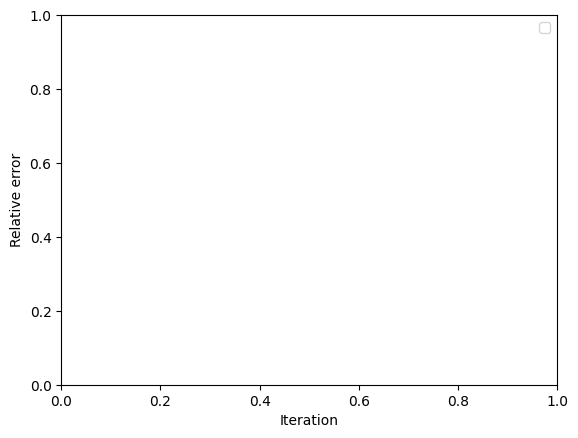

In [7]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
styles = [":", "--", "-"]
colors = ["#70CEFF", "#C756B2", "#FFE096"]
for (name, energy), c, ls in zip(energies.items(), colors, styles):
    error = (energy - E_min_noisy) / abs(E_min_noisy)
    ax.plot(list(range(len(error))), error, label=name, c=c, ls=ls, lw=2.5)

ax.set(xlabel="Iteration", ylabel="Relative error")
ax.legend()
plt.show()

In [2]:
import pennylane as qml
import numpy as np
import jax.numpy as jnp
import jax

num_wires = 4  # Number of qubits
loc = 2  # Local dimension for two-qubit operations
d = loc**4 - 1  # Number of parameters for two-qubit operations (15 for SU(4))
dev = qml.device("default.qubit", wires=num_wires)

# Initialize parameters for different circuit repetitions
repetitions = [2,4,6,8,10]
param_shapes = [(rep, 2, 2, d) for rep in repetitions]
init_params_list = [np.random.randn(*shape) for shape in param_shapes]


# Define the quantum circuit function
def circuit(params, operation=None):
    """Apply an operation in a brickwall-like pattern to a qubit register and measure H.
    Parameters are assumed to have the dimensions (number of blocks, number of
    wires per operation, number of operations per layer, and number of parameters
    per operation), in that order.
    """
    for params_block in params:
        for i, params_layer in enumerate(params_block):
            for j, params_op in enumerate(params_layer):
                wires_op = [(loc * j + i + w) % num_wires for w in range(loc)]
                operation(params_op, wires_op)
    return qml.expval(noisy_H)

# Create QNodes for different circuit repetitions
qnodes = [qml.QNode(circuit, dev, interface="jax") for _ in repetitions]


#print(qml.draw(qnodes[-1])(init_params_list[-1], qml.SpecialUnitary))

#qnodes[0](init_params_list[0], qml.SpecialUnitary)#(params,operation)


In [7]:
# Define the learning parameters for optimization
learning_rate = 5e-4
num_steps = 200
#grad_fn = jax.jit(jax.jacobian(qnode), static_argnums=1)

# Define a function to run optimization for each circuit repetition
def optimize(i, operation): # i stands for repetition index
    grad_fn = jax.jit(jax.jacobian(qnodes[i]), static_argnums=1)
    energies = []
    params = init_params_list[i]
    qnode
    for step in range(num_steps):
        cost = qnodes[i](params,operation)
        params = params - learning_rate * grad_fn(params, operation)
        energies.append(cost)
    energies.append(cost)
    return energies


In [10]:
# Plot the relative errors for Special Unitary operations
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i,rep in enumerate(repetitions):
    e = optimize(i,qml.SpecialUnitary)
    error = (e - E_min_noisy) / abs(E_min_noisy)

    color = plt.cm.plasma(i / len(repetitions))  # Get color from a colormap
    plt.plot(np.arange(num_steps+1), error, color=color, label=f"Circuit Repetitions = {rep}")  # Label each curve
plt.title("Energy for SU Operations( Max-Cut Problem- 4 Qubits)")
plt.xlabel("Step")
plt.ylabel("Relative Error")
plt.legend()
plt.grid(True)
plt.show()

c:\Users\DELL\anaconda3\envs\qiskit\Lib\site-packages\jax\_src\lax\lax.py:2745: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
c:\Users\DELL\anaconda3\envs\qiskit\Lib\site-packages\jax\_src\lax\lax.py:2745: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
c:\Users\DELL\anaconda3\envs\qiskit\Lib\site-packages\jax\_src\lax\lax.py:2745: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming final_energies dictionary has been created
# final_energies = {steps: [] for steps in steps_list}

def optimize(i, operation, num_steps): # i stands for repetition index
    grad_fn = jax.jit(jax.jacobian(qnodes[i]), static_argnums=1)
    energies = []
    params = init_params_list[i]
    for step in range(num_steps):
        cost = qnodes[i](params,operation)
        params = params - learning_rate * grad_fn(params, operation)
        energies.append(cost)
    energies.append(cost)
    return energies

# Define the list of repetitions and steps
steps_list = [50, 100, 150, 200, 250, 300]
final_energies = {}
# create final_energies Dict
for steps in steps_list:
    lst = []
    for i,rep in enumerate(repetitions):
        e = optimize(i,qml.ArbitraryUnitary,steps)
        lst.append(abs(e[-1]))
    final_energies[steps] = lst

final_energies        

{50: [Array(18.011768, dtype=float32),
  Array(23.324076, dtype=float32),
  Array(25.61138, dtype=float32),
  Array(23.840097, dtype=float32),
  Array(25.441788, dtype=float32)],
 100: [Array(21.020145, dtype=float32),
  Array(25.543919, dtype=float32),
  Array(26.516054, dtype=float32),
  Array(26.051357, dtype=float32),
  Array(26.420828, dtype=float32)],
 150: [Array(22.37937, dtype=float32),
  Array(26.03522, dtype=float32),
  Array(26.640589, dtype=float32),
  Array(26.486101, dtype=float32),
  Array(26.651876, dtype=float32)],
 200: [Array(23.336624, dtype=float32),
  Array(26.236208, dtype=float32),
  Array(26.664444, dtype=float32),
  Array(26.595915, dtype=float32),
  Array(26.716797, dtype=float32)],
 250: [Array(24.135857, dtype=float32),
  Array(26.354166, dtype=float32),
  Array(26.670301, dtype=float32),
  Array(26.635818, dtype=float32),
  Array(26.736431, dtype=float32)],
 300: [Array(24.79219, dtype=float32),
  Array(26.434732, dtype=float32),
  Array(26.672104, dtype=

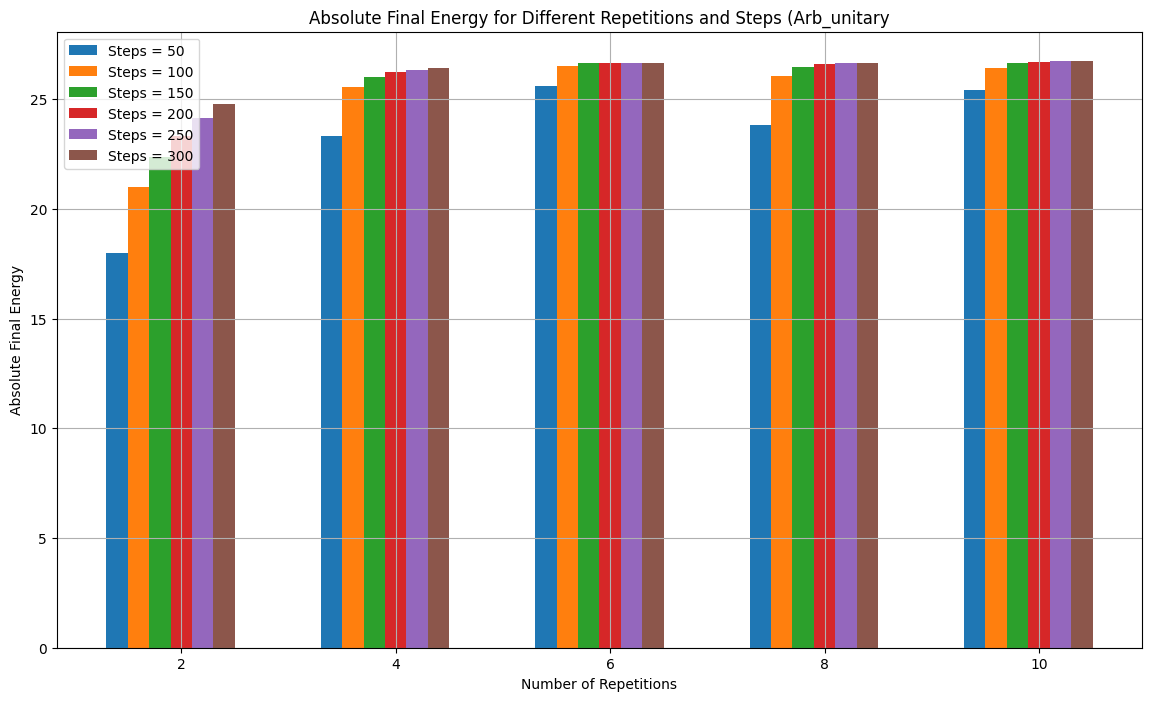

In [9]:
# Plotting the grouped bar chart
bar_width = 0.1
x = np.arange(len(repetitions))

plt.figure(figsize=(14, 8))

for i, steps in enumerate(steps_list):
    plt.bar(x + i * bar_width, final_energies[steps], bar_width, label=f"Steps = {steps}")

plt.xlabel("Number of Repetitions")
plt.ylabel("Absolute Final Energy")
plt.title("Absolute Final Energy for Different Repetitions and Steps (Arb_unitary")
plt.xticks(x + bar_width * (len(steps_list) / 2), repetitions)
plt.legend()
plt.grid(True)
plt.show()

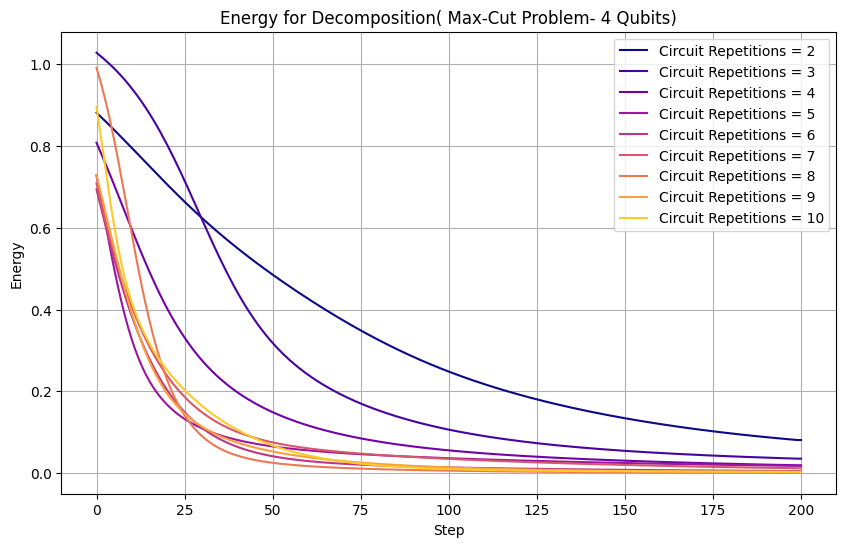

In [ ]:
# Plot the relative errors for Special Unitary operations
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i,rep in enumerate(repetitions):
    e = optimize(i,two_qubit_decomp)
    error = (e - E_min_noisy) / abs(E_min_noisy)

    color = plt.cm.plasma(i / len(repetitions))  # Get color from a colormap
    plt.plot(np.arange(num_steps+1), error, color=color, label=f"Circuit Repetitions = {rep}")  # Label each curve
plt.title("Energy for Decomposition( Max-Cut Problem- 4 Qubits)")
plt.xlabel("Step")
plt.ylabel("Energy")
plt.legend()
plt.grid(True)
plt.show()


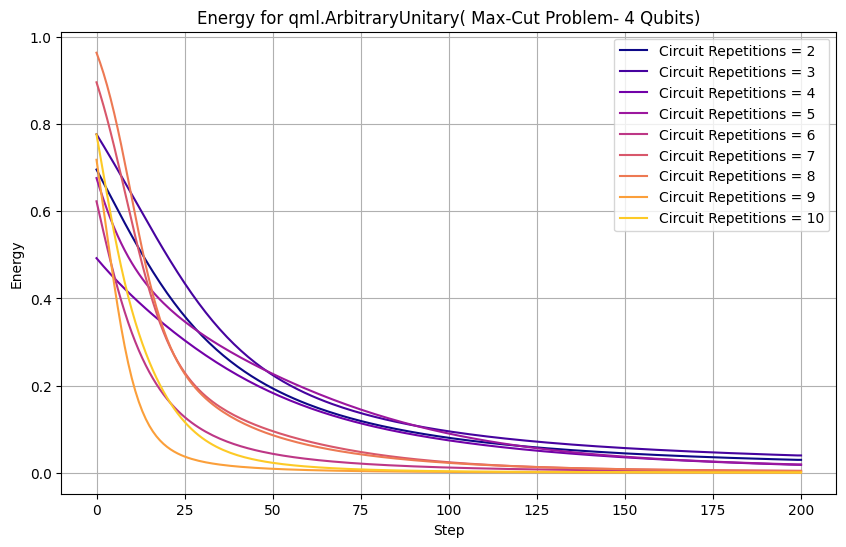

In [ ]:
# Plot the relative errors for Special Unitary operations
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i,rep in enumerate(repetitions):
    e = optimize(i,qml.ArbitraryUnitary)
    error = (e - E_min_noisy) / abs(E_min_noisy)

    color = plt.cm.plasma(i / len(repetitions))  # Get color from a colormap
    plt.plot(np.arange(num_steps+1), error, color=color, label=f"Circuit Repetitions = {rep}")  # Label each curve
plt.title("Energy for qml.ArbitraryUnitary( Max-Cut Problem- 4 Qubits)")
plt.xlabel("Step")
plt.ylabel("Energy")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
# import sympy 
from sympy import *
 
x, y = symbols('x y')
expr = x**2 + 2 * y + y**3
print("Expression : {}".format(expr))
  
# Use sympy.Derivative() method 
expr_diff = Derivative(expr, x)  
     
print("Derivative of expression with respect to x : {}".format(expr_diff))  
print("Value of the derivative : {}".format(expr_diff.doit()))

Expression : x**2 + y**3 + 2*y
Derivative of expression with respect to x : Derivative(x**2 + y**3 + 2*y, x)
Value of the derivative : 2*x
